Import the libraries necessary to analize data

In [327]:
%matplotlib inline
import math
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
import datetime
import random
import seaborn as sns
import plotly.express as px

from collections import defaultdict
from scipy.stats import pearsonr

# Incidents

Import the incidents csv file

In [328]:
df = pd.read_csv('incidents_df_joined.csv', low_memory=False, sep=',', parse_dates=['date']) #alternative in case of json source df.to_json('filename.json')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 199379 entries, 0 to 199378
Data columns (total 33 columns):
 #   Column                     Non-Null Count   Dtype         
---  ------                     --------------   -----         
 0   date                       199379 non-null  datetime64[ns]
 1   state                      199379 non-null  object        
 2   city_or_county             199379 non-null  object        
 3   address                    185728 non-null  object        
 4   latitude                   199313 non-null  float64       
 5   longitude                  199313 non-null  float64       
 6   congressional_district     199379 non-null  float64       
 7   state_house_district       178208 non-null  float64       
 8   state_senate_district      184240 non-null  float64       
 9   participant_age1           136187 non-null  float64       
 10  participant_age_group1     161305 non-null  object        
 11  participant_gender1        166716 non-null  object  

Change data types to match the content of each attribute

In [329]:
df["date"] = df["date"].astype("datetime64[ns]")
df["state"] = df["state"].astype("string")
df["city_or_county"] = df["city_or_county"].astype("string")
df["address"] = df["address"].astype("string")
df["congressional_district"] = df["congressional_district"].astype("Int64")
df["state_house_district"] = df["state_house_district"].astype("Int64")
df["state_senate_district"] = df["state_senate_district"].astype("Int64")
df["participant_age1"] = df["participant_age1"].astype("Int64")
df["min_age_participants"] = pd.to_numeric(df["min_age_participants"], errors="coerce").astype("Int64")
df["max_age_participants"] = pd.to_numeric(df["max_age_participants"], errors="coerce").astype("Int64")
df["avg_age_participants"] = pd.to_numeric(df["avg_age_participants"], errors="coerce").astype("float64")
df[df['participant_gender1'] == 'Male, female'] = np.nan
df["participant_gender1"] = df["participant_gender1"].astype("string")
df["participant_age_group1"] = df["participant_age_group1"].astype("string")
df["n_participants_teen"] = pd.to_numeric(df["n_participants_teen"], errors="coerce").astype("Int64")
df["n_participants_child"] = pd.to_numeric(df["n_participants_child"], errors="coerce").astype("Int64")
df["n_participants_adult"] = pd.to_numeric(df["n_participants_adult"], errors="coerce").astype("Int64")
df["n_males"] = pd.to_numeric(df["n_males"], errors="coerce").astype("Int64")
df["n_females"] = pd.to_numeric(df["n_females"], errors="coerce").astype("Int64")
df["n_killed"] = pd.to_numeric(df["n_killed"], errors="coerce").astype("Int64")
df["n_injured"] = pd.to_numeric(df["n_injured"], errors="coerce").astype("Int64")
df["n_arrested"] = pd.to_numeric(df["n_arrested"], errors="coerce").astype("Int64")
df["n_unharmed"] = pd.to_numeric(df["n_unharmed"], errors="coerce").astype("Int64")
df["n_participants"] = pd.to_numeric(df["n_participants"], errors="coerce").astype("Int64")
df["notes"] = df["notes"].astype("string")
df["incident_characteristics1"] = df["incident_characteristics1"].astype("string")
df["incident_characteristics2"] = df["incident_characteristics2"].astype("string")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 199379 entries, 0 to 199378
Data columns (total 33 columns):
 #   Column                     Non-Null Count   Dtype         
---  ------                     --------------   -----         
 0   date                       199378 non-null  datetime64[ns]
 1   state                      199378 non-null  string        
 2   city_or_county             199378 non-null  string        
 3   address                    185727 non-null  string        
 4   latitude                   199312 non-null  float64       
 5   longitude                  199312 non-null  float64       
 6   congressional_district     199378 non-null  Int64         
 7   state_house_district       178207 non-null  Int64         
 8   state_senate_district      184239 non-null  Int64         
 9   participant_age1           136186 non-null  Int64         
 10  participant_age_group1     161304 non-null  string        
 11  participant_gender1        166715 non-null  string  

Deleting the rows with all NaN values

In [330]:
print(f"df len before: {len(df)}")
df.dropna(how='all', inplace=True)
print(f"df len after: {len(df)}")

df len before: 199379
df len after: 199378


Removing negative values

In [331]:
columns_to_check = ['participant_age1', 'min_age_participants', 'avg_age_participants',
       'max_age_participants', 'n_participants_child', 'n_participants_teen',
       'n_participants_adult', 'n_males', 'n_females', 'n_killed', 'n_injured',
       'n_arrested', 'n_unharmed', 'n_participants']
# Set values less than 0 to NaN for the specified columns
for i in columns_to_check:
    df.loc[df[i] < 0, i] = np.nan


## Age


As seen in D.U., given that there are some ouliers in the order of ~800 years of age, we decided to remove them by setting them all to NaN, considering that a person with more than 120 years has not ever lived [cite, wikipedia].

In [332]:
df.loc[(df["avg_age_participants"] > 120), "avg_age_participants"] = np.nan
df.loc[(df['min_age_participants'] > 120), "min_age_participants"] = np.nan
df.loc[(df['max_age_participants'] > 120), "max_age_participants"] = np.nan
df.loc[(df["participant_age1"] > 120), "participant_age1"] = np.nan

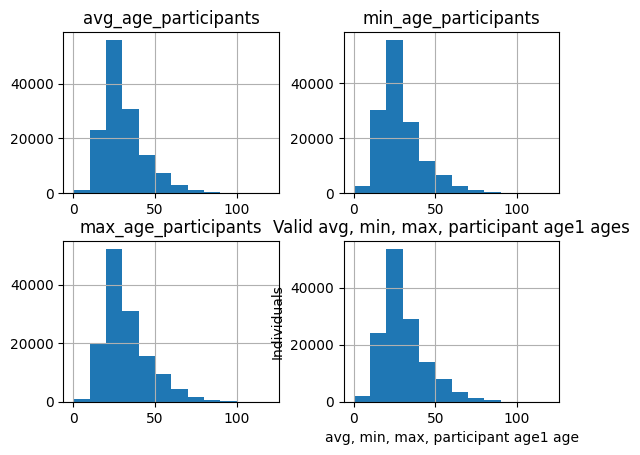

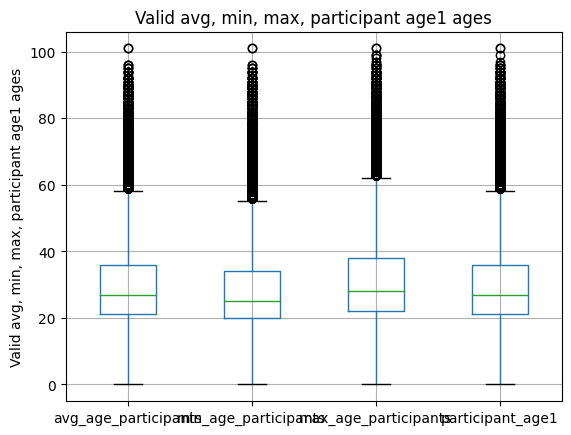

In [333]:

df.hist(column=['avg_age_participants', 'min_age_participants', 'max_age_participants', 'participant_age1'], bins=[i for i in range(0,121,10)])
plt.title("Valid avg, min, max, participant age1 ages")
plt.xlabel("avg, min, max, participant age1 age")
plt.ylabel("Individuals")
plt.show()

df.boxplot(column=['avg_age_participants', 'min_age_participants', 'max_age_participants', 'participant_age1'])
plt.title("Valid avg, min, max, participant age1 ages")
plt.ylabel("Valid avg, min, max, participant age1 ages")
plt.show()

In [334]:
df[['avg_age_participants', 'participant_age1', 'min_age_participants', 'max_age_participants']].describe()

,avg_age_participants,participant_age1,min_age_participants,max_age_participants
count,136184.000000,136184.0,136188.0,136185.0
mean,29.974858,30.260816,28.325763,31.764746
std,12.461499,13.343577,12.498695,13.709934
min,0.000000,0.0,0.0,0.0
25%,21.000000,21.0,20.0,22.0
50%,27.000000,27.0,25.0,28.0
75%,36.000000,36.0,34.0,38.0
max,101.000000,101.0,101.0,101.0


#TODO reason after on corr matrix

In [335]:
corr_matrix = df[['participant_age1', 'participant_age_group1',
       'participant_gender1', 'min_age_participants', 'avg_age_participants',
       'max_age_participants', 'n_participants_child', 'n_participants_teen',
       'n_participants_adult', 'n_males', 'n_females', 'n_killed', 'n_injured',
       'n_arrested', 'n_unharmed', 'n_participants', 'povertyPercentage']].corr(numeric_only=True, method='pearson')
corr_matrix

,participant_age1,min_age_participants,avg_age_participants,max_age_participants,n_participants_child,n_participants_teen,n_participants_adult,n_males,n_females,n_killed,n_injured,n_arrested,n_unharmed,n_participants,povertyPercentage
participant_age1,1.000000,0.877498,0.945114,0.926076,-0.002130,-0.002775,-0.002013,-0.059980,0.068523,0.141669,-0.119807,-0.025742,-0.009029,-0.033587,0.033498
min_age_participants,0.877498,1.000000,0.951124,0.810780,-0.001497,-0.002601,-0.001497,-0.185675,-0.018991,0.056328,-0.151565,-0.108021,-0.046042,-0.179156,0.013015
avg_age_participants,0.945114,0.951124,1.000000,0.948221,-0.002165,-0.003038,-0.002132,-0.093665,0.063569,0.131257,-0.119072,-0.052561,-0.021108,-0.065437,0.030001
max_age_participants,0.926076,0.810780,0.948221,1.000000,-0.002622,-0.003195,-0.002565,0.020842,0.144300,0.193053,-0.071779,0.021609,0.009396,0.068696,0.043624
n_participants_child,-0.002130,-0.001497,-0.002165,-0.002622,1.000000,1.000000,1.000000,-0.002453,-0.002057,-0.000986,-0.001663,0.000013,-0.002289,-0.002159,0.000426
n_participants_teen,-0.002775,-0.002601,-0.003038,-0.003195,1.000000,1.000000,0.957443,-0.000244,-0.001847,0.006318,-0.002978,-0.001203,-0.002054,-0.001254,-0.001756
n_participants_adult,-0.002013,-0.001497,-0.002132,-0.002565,1.000000,0.957443,1.000000,-0.000556,-0.002264,0.003766,-0.001882,-0.000670,-0.002529,-0.001751,-0.003288
n_males,-0.059980,-0.185675,-0.093665,0.020842,-0.002453,-0.000244,-0.000556,1.000000,-0.053005,0.145219,0.261547,0.389389,0.413075,0.826298,0.055298
n_females,0.068523,-0.018991,0.063569,0.144300,-0.002057,-0.001847,-0.002264,-0.053005,1.000000,0.194010,0.164088,0.119741,0.132576,0.383099,0.056898
n_killed,0.141669,0.056328,0.131257,0.193053,-0.000986,0.006318,0.003766,0.145219,0.194010,1.000000,-0.114852,-0.069686,-0.134348,0.262089,0.066520


<Axes: >

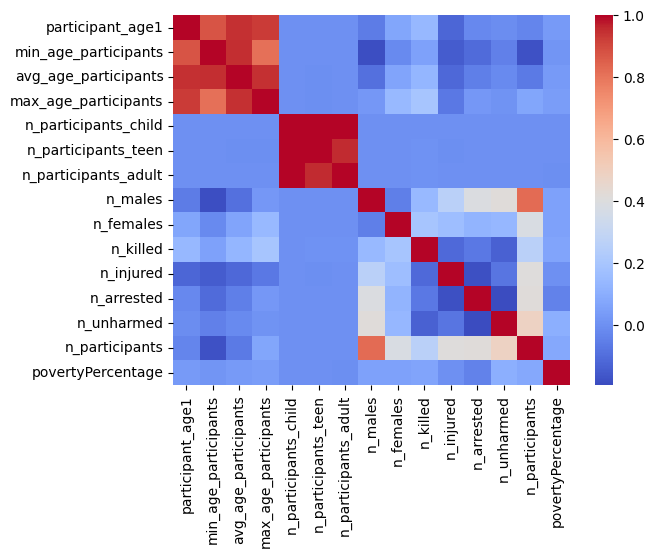

In [336]:
sns.heatmap(corr_matrix, annot=False, cmap='coolwarm')

In [337]:
print(f"% of no child in incidents: {df[df['n_participants_child'] == 0]['n_participants_child'].count() / len(df['n_participants_child'])}")
print(f"% of no teen in incidents: {df[df['n_participants_teen'] == 0]['n_participants_teen'].count() / len(df['n_participants_teen'])}")
print(f"% of no adult in incidents: {df[df['n_participants_adult'] == 0]['n_participants_adult'].count() / len(df['n_participants_adult'])}")

% of no child in incidents: 0.7925949703578128
% of no teen in incidents: 0.7222060608492411
% of no adult in incidents: 0.05159546188646691


We notice from eliminated obvious outliers (>120 and <0 years of age) and plotting the results that [avg_age,min_age,max_age]_participants are very similar (same min and max age, similar mean and median), so we decide that we will further explore their correlation. 

We check if when avg_age_participants is 0 or null, we can infer it by calcultating the avg based on min_age_participants and max_age_participants, and we found 0 rows available.
This is a further motivation to delete min and max age participants

In [338]:
df[((df['avg_age_participants'] == 0) | (df['avg_age_participants'].isna())) & (((df['min_age_participants'] > 0) & (df['min_age_participants'].notna())) & ((df['max_age_participants'] > 0) & df['min_age_participants'].notna() ))] [['avg_age_participants', 'min_age_participants', 'max_age_participants']]

,avg_age_participants,min_age_participants,max_age_participants


In [339]:
"""
df[df["min_age_participants"].isna() & (df["n_participants_adult"].isna() & (df["n_participants_teen"].isna()) & (df["n_participants_child"].isna()))][["n_participants_child","n_participants_adult","n_participants_teen","min_age_participants"]]
 #modify the min_age_participants, max_age_participants null values by taking the column value according to this three columns "n_participants_adult", "n_participants_teen" and "n_participants_child" (TODO COMMENTO)
#min_age_participants
#1 child
condition = (df["min_age_participants"] < 12) & (df["min_age_participants"] > 0)
internalCondition  =(df["min_age_participants"].isna()) & (df["n_participants_child"].notna()) & (df["n_participants_child"] > 0)
df.loc[internalCondition, "min_age_participants"] = np.random.choice(df.loc[condition, "min_age_participants"], size=internalCondition.sum())
#2 teen
condition = (df["min_age_participants"] <= 17) & (df["min_age_participants"] > 11)
internalCondition  =(df["min_age_participants"].isna()) & (df["n_participants_teen"].notna()) & (df["n_participants_teen"] > 0)
df.loc[internalCondition, "min_age_participants"]= np.random.choice(df.loc[condition]["min_age_participants"], size=internalCondition.sum())
#3 adult
condition = (df["min_age_participants"] < df["max_age_participants"]) & (df["min_age_participants"] > 17) & (df["min_age_participants"] < 101)
internalCondition  = (df["min_age_participants"].isna()) & (df["n_participants_adult"].notna()) & (df["n_participants_adult"] > 0)
df.loc[internalCondition, "min_age_participants"]= np.random.choice(df.loc[condition]["min_age_participants"], size=internalCondition.sum())
df.info() """

'\ndf[df["min_age_participants"].isna() & (df["n_participants_adult"].isna() & (df["n_participants_teen"].isna()) & (df["n_participants_child"].isna()))][["n_participants_child","n_participants_adult","n_participants_teen","min_age_participants"]]\n #modify the min_age_participants, max_age_participants null values by taking the column value according to this three columns "n_participants_adult", "n_participants_teen" and "n_participants_child" (TODO COMMENTO)\n#min_age_participants\n#1 child\ncondition = (df["min_age_participants"] < 12) & (df["min_age_participants"] > 0)\ninternalCondition  =(df["min_age_participants"].isna()) & (df["n_participants_child"].notna()) & (df["n_participants_child"] > 0)\ndf.loc[internalCondition, "min_age_participants"] = np.random.choice(df.loc[condition, "min_age_participants"], size=internalCondition.sum())\n#2 teen\ncondition = (df["min_age_participants"] <= 17) & (df["min_age_participants"] > 11)\ninternalCondition  =(df["min_age_participants"].isna

In [340]:

""" #modify the  max_age_participants null values by taking the column value according to this three columns "n_participants_adult", "n_participants_teen" and "n_participants_child" (TODO COMMENTO)
#min_age_participants
#1 adult
condition = (df["max_age_participants"] > 17) & (df["max_age_participants"] < 60)
internalCondition  = (df["max_age_participants"].isna()) & (df["n_participants_adult"].notna()) & (df["n_participants_adult"] > 0)
df.loc[internalCondition, "max_age_participants"]= np.random.choice(df.loc[condition]["max_age_participants"], size=internalCondition.sum())
#2 teen
condition = (df["max_age_participants"] < 17) & (df["max_age_participants"] > 11)
internalCondition  =(df["max_age_participants"].isna()) & (df["n_participants_teen"].notna()) & (df["n_participants_teen"] > 0)
df.loc[internalCondition, "max_age_participants"]= np.random.choice(df.loc[condition]["max_age_participants"], size=internalCondition.sum())
#3 child
condition = (df["max_age_participants"] < 12) & (df["max_age_participants"] > 0)
internalCondition  =(df["max_age_participants"].isna()) & (df["n_participants_child"].notna()) & (df["n_participants_child"] > 0)
df.loc[internalCondition, "max_age_participants"] = np.random.choice(df.loc[condition, "max_age_participants"], size=internalCondition.sum())


df.info() """

' #modify the  max_age_participants null values by taking the column value according to this three columns "n_participants_adult", "n_participants_teen" and "n_participants_child" (TODO COMMENTO)\n#min_age_participants\n#1 adult\ncondition = (df["max_age_participants"] > 17) & (df["max_age_participants"] < 60)\ninternalCondition  = (df["max_age_participants"].isna()) & (df["n_participants_adult"].notna()) & (df["n_participants_adult"] > 0)\ndf.loc[internalCondition, "max_age_participants"]= np.random.choice(df.loc[condition]["max_age_participants"], size=internalCondition.sum())\n#2 teen\ncondition = (df["max_age_participants"] < 17) & (df["max_age_participants"] > 11)\ninternalCondition  =(df["max_age_participants"].isna()) & (df["n_participants_teen"].notna()) & (df["n_participants_teen"] > 0)\ndf.loc[internalCondition, "max_age_participants"]= np.random.choice(df.loc[condition]["max_age_participants"], size=internalCondition.sum())\n#3 child\ncondition = (df["max_age_participants"] 

## Date

Analysis and cleaning of the date attribute

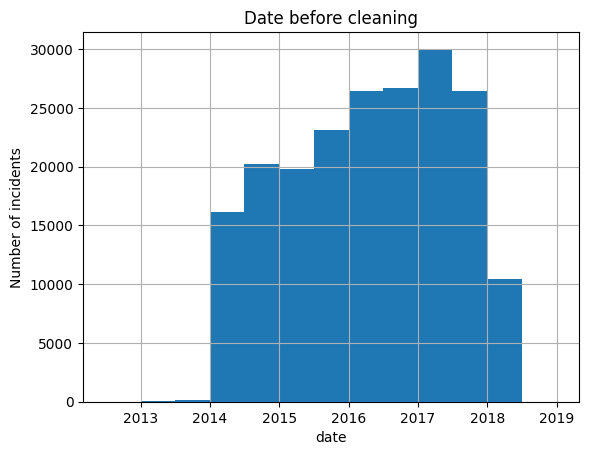

In [341]:
df.hist(column=["date"],   bins=[datetime.datetime(2012,7,1,0,0), datetime.datetime(2013,1,1,0,0), datetime.datetime(2013,7,1,0,0),
                             datetime.datetime(2014,1,1,0,0), datetime.datetime(2014,7,1,0,0), datetime.datetime(2015,1,1,0,0),
                             datetime.datetime(2015,7,1,0,0), datetime.datetime(2016,1,1,0,0), datetime.datetime(2016,7,1,0,0),
                             datetime.datetime(2017,1,1,0,0), datetime.datetime(2017,7,1,0,0), datetime.datetime(2018,1,1,0,0),
                             datetime.datetime(2018,7,1,0,0), datetime.datetime(2019,1,1,0,0)])
plt.title("Date before cleaning")
plt.xlabel("date")
plt.ylabel("Number of incidents")
plt.show()

We considered all dates after 2023-10-01 (the date we received the dataset) to be ouliers, in particular error in the data

TODO: Drop 2013 records,
2018 analyze separately

# Geographical info

## Latitude and longitude

In [360]:
central_block = ((df["latitude"] <= 49.3457868) & (df["latitude"] >= 24.396308) & (df["longitude"] >= -125.000000) & (df["longitude"] <= -66.934570))
alaska_block = ((df["latitude"] <= 71.635993) & (df["latitude"] >= 53.67068) & (df["longitude"] >= -173.59497) & (df["longitude"] <= -129.152344))
hawaii_block = ((df["latitude"] <= 22.674847) & (df["latitude"] >= 17.790535) & (df["longitude"] >= -161.389160) & (df["longitude"] <= -153.237305))

df[~(central_block | alaska_block | hawaii_block)][['latitude', 'longitude']].value_counts(dropna=False)

latitude  longitude
NaN       NaN          66
Name: count, dtype: int64

We consider the triple <date,latitude,longitude> to be identifying of the incident. So we decided to remove all records that had all these three values to NaN

In [19]:
print(len(df))
#print duplicates columns if they are not NaN
#df = df.drop_duplicates(subset=["date", "latitude", "longitude"]).append(df[pd.isnull(df['date']) | pd.isnull(df['latitude']) | pd.isnull(df['longitude'])])
df = pd.concat([df[pd.isnull(df['date']) | pd.isnull(df['latitude']) | pd.isnull(df['longitude'])], df.drop_duplicates(subset=["date", "latitude", "longitude"])])
df.drop_duplicates(inplace=True)
print(len(df))

199378
198167


## Filling of missing values and outliers

In [20]:
#Sostituisco i valori NaN di latitude e longitude, con i valori delle righe aventi lo stesso state e la stessa city_or_county
df[['latitude', 'longitude']] = df.groupby(["state", "city_or_county"],group_keys=False)[['latitude', 'longitude']].apply(lambda x: x.fillna(x.mean()))
df[['latitude', 'longitude']] = df.groupby("state",group_keys=False)[['latitude', 'longitude']].apply(lambda x: x.fillna(x.mean()))
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 198167 entries, 85424 to 199378
Data columns (total 33 columns):
 #   Column                     Non-Null Count   Dtype         
---  ------                     --------------   -----         
 0   date                       198167 non-null  datetime64[ns]
 1   state                      198167 non-null  string        
 2   city_or_county             198167 non-null  string        
 3   address                    184771 non-null  string        
 4   latitude                   198167 non-null  float64       
 5   longitude                  198167 non-null  float64       
 6   congressional_district     198167 non-null  Int64         
 7   state_house_district       177094 non-null  Int64         
 8   state_senate_district      183086 non-null  Int64         
 9   participant_age1           135551 non-null  Int64         
 10  participant_age_group1     160568 non-null  string        
 11  participant_gender1        165953 non-null  string   

# Participant quantity information 
('n_participants_child', 'n_participants_teen',
       'n_participants_adult', 'n_males', 'n_females', 'n_killed', 'n_injured',
       'n_arrested', 'n_unharmed', 'n_participants')

#TODO to check..

In [21]:
# Calculate the values to substitute, utilizza n_females, n_males
#Utilizzerà questi valori per sosituire "n_participants" nel caso somma tra male e female è pari alla somma tra teen,child e adults.
#La modifica per quanto riguarda "n_participants" è fatta solo se è diversa da tutte le altre somme delle varie colonne:
#1) females + males
#2) child + adult + teen
#3) killed+injured+unharmed+arrested
#Nel caso in cui n_partiicpants sia almeno uguale ad una delle altre somme => lascia uguale.
df['substitute_values'] = df['n_females'] + df['n_males']

# Define the condition for substitution
condition = (
    (df['n_participants'] != (df['n_females'] + df['n_males'])) &
    (df['n_participants'] != (df['n_participants_adult'] + df['n_participants_child'] + df['n_participants_teen'])) &
    (df['n_participants'] != (df['n_killed'] + df['n_injured'] + df['n_unharmed'] + df['n_arrested'])) & # TODO: not correct
    ((df['n_females'] + df['n_males']) == (df['n_participants_teen'] + df['n_participants_child'] + df['n_participants_adult']))
)

# Update the "n_participants" column with the calculated values where the condition is met
df.loc[condition, 'n_participants'] = df.loc[condition, 'substitute_values']

# Drop the temporary "substitute_values" column if needed
df.drop(columns='substitute_values', inplace=True)

df[
        (df['n_participants'] != (df["n_females"] + df["n_males"])) & 
        (df['n_participants'] != (df["n_participants_adult"] + df["n_participants_child"] + df["n_participants_teen"])) &
        (df["n_participants"] != (df["n_killed"] + df["n_injured"] + df["n_unharmed"] + df["n_arrested"])
    ) &
    (
        (df['n_females'] + df['n_males']) == (df['n_participants_adult'] + df['n_participants_child'] + df['n_participants_teen'])
    )
][["n_participants","n_males","n_females", "n_participants_teen", "n_participants_child", "n_participants_adult", "n_killed", "n_injured", "n_unharmed", "n_arrested"]]
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 198167 entries, 85424 to 199378
Data columns (total 33 columns):
 #   Column                     Non-Null Count   Dtype         
---  ------                     --------------   -----         
 0   date                       198167 non-null  datetime64[ns]
 1   state                      198167 non-null  string        
 2   city_or_county             198167 non-null  string        
 3   address                    184771 non-null  string        
 4   latitude                   198167 non-null  float64       
 5   longitude                  198167 non-null  float64       
 6   congressional_district     198167 non-null  Int64         
 7   state_house_district       177094 non-null  Int64         
 8   state_senate_district      183086 non-null  Int64         
 9   participant_age1           135551 non-null  Int64         
 10  participant_age_group1     160568 non-null  string        
 11  participant_gender1        165953 non-null  string   

In [22]:
# Calculate the values to substitute, utilizza harmed,killed,unharmed,injured per la condizione di somma.
df['substitute_values'] = df['n_females'] + df['n_males']

# Define the condition for substitution
condition = (
    (df['n_participants'] != (df['n_females'] + df['n_males'])) &
    (df['n_participants'] != (df['n_participants_adult'] + df['n_participants_child'] + df['n_participants_teen'])) &
    (df['n_participants'] != (df['n_killed'] + df['n_injured'] + df['n_unharmed'] + df['n_arrested'])) &
    ((df['n_females'] + df['n_males']) == (df['n_killed'] + df['n_injured'] + df['n_unharmed'] + df['n_arrested']))
)

# Update the "n_participants" column with the calculated values where the condition is met
df.loc[condition, 'n_participants'] = df.loc[condition, 'substitute_values']

# Drop the temporary "substitute_values" column if needed
df.drop(columns='substitute_values', inplace=True)

df[
        (df['n_participants'] != (df["n_females"] + df["n_males"])) & 
        (df['n_participants'] != (df["n_participants_adult"] + df["n_participants_child"] + df["n_participants_teen"])) &
        (df["n_participants"] != (df["n_killed"] + df["n_injured"] + df["n_unharmed"] + df["n_arrested"])
    ) &
    (
        (df['n_females'] + df['n_males']) == (df['n_killed'] + df['n_injured'] + df['n_unharmed'] + df['n_arrested'])
    )
][["n_participants","n_males","n_females", "n_participants_teen", "n_participants_child", "n_participants_adult", "n_killed", "n_injured", "n_unharmed", "n_arrested"]]
df.info()


<class 'pandas.core.frame.DataFrame'>
Index: 198167 entries, 85424 to 199378
Data columns (total 33 columns):
 #   Column                     Non-Null Count   Dtype         
---  ------                     --------------   -----         
 0   date                       198167 non-null  datetime64[ns]
 1   state                      198167 non-null  string        
 2   city_or_county             198167 non-null  string        
 3   address                    184771 non-null  string        
 4   latitude                   198167 non-null  float64       
 5   longitude                  198167 non-null  float64       
 6   congressional_district     198167 non-null  Int64         
 7   state_house_district       177094 non-null  Int64         
 8   state_senate_district      183086 non-null  Int64         
 9   participant_age1           135551 non-null  Int64         
 10  participant_age_group1     160568 non-null  string        
 11  participant_gender1        165953 non-null  string   

In [23]:
# Calculate the values to substitute, teen,adult e child con injured,killed,unharmed,arrested come condizione, e adult,teen,child come sostituto.
df['substitute_values'] = (df['n_participants_adult'] + df['n_participants_child'] + df['n_participants_teen'])

# Define the condition for substitution
condition = (
    (df['n_participants'] != (df['n_females'] + df['n_males'])) &
    (df['n_participants'] != (df['n_participants_adult'] + df['n_participants_child'] + df['n_participants_teen'])) &
    (df['n_participants'] != (df['n_killed'] + df['n_injured'] + df['n_unharmed'] + df['n_arrested'])) &
    ((df['n_killed'] + df['n_injured'] + df['n_unharmed'] + df['n_arrested']) == (df['n_participants_adult'] + df['n_participants_child'] + df['n_participants_teen']))
)

# Update the "n_participants" column with the calculated values where the condition is met
df.loc[condition, 'n_participants'] = df.loc[condition, 'substitute_values']

# Drop the temporary "substitute_values" column if needed
df.drop(columns='substitute_values', inplace=True)

df[
        (df['n_participants'] != (df["n_females"] + df["n_males"])) & 
        (df['n_participants'] != (df["n_participants_adult"] + df["n_participants_child"] + df["n_participants_teen"])) &
        (df["n_participants"] != (df["n_killed"] + df["n_injured"] + df["n_unharmed"] + df["n_arrested"])
    ) &
    (
        (df['n_participants_adult'] + df['n_participants_child'] + df['n_participants_teen']) == (df['n_killed'] + df['n_injured'] + df['n_unharmed'] + df['n_arrested'])
    )
][["n_participants","n_males","n_females", "n_participants_teen", "n_participants_child", "n_participants_adult", "n_killed", "n_injured", "n_unharmed", "n_arrested"]]
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 198167 entries, 85424 to 199378
Data columns (total 33 columns):
 #   Column                     Non-Null Count   Dtype         
---  ------                     --------------   -----         
 0   date                       198167 non-null  datetime64[ns]
 1   state                      198167 non-null  string        
 2   city_or_county             198167 non-null  string        
 3   address                    184771 non-null  string        
 4   latitude                   198167 non-null  float64       
 5   longitude                  198167 non-null  float64       
 6   congressional_district     198167 non-null  Int64         
 7   state_house_district       177094 non-null  Int64         
 8   state_senate_district      183086 non-null  Int64         
 9   participant_age1           135551 non-null  Int64         
 10  participant_age_group1     160568 non-null  string        
 11  participant_gender1        165953 non-null  string   

# Poverty by State

Import the povertyByStateYear csv file

In [24]:
poverty_df = pd.read_csv('povertyByStateYear.csv', sep=',')
poverty_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 884 entries, 0 to 883
Data columns (total 3 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   state              884 non-null    object 
 1   year               884 non-null    int64  
 2   povertyPercentage  832 non-null    float64
dtypes: float64(1), int64(1), object(1)
memory usage: 20.8+ KB


Change data types to match the content of each attribute

In [25]:
poverty_df["state"] = poverty_df["state"].astype("string")
poverty_df["year"] = poverty_df["year"].astype("Int64")

# Year State District House

Import the year_state_district_house csv file

In [26]:
district_in_state_df = pd.read_csv('year_state_district_house.csv', sep=',')
district_in_state_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10441 entries, 0 to 10440
Data columns (total 6 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   year                    10441 non-null  int64 
 1   state                   10441 non-null  object
 2   congressional_district  10441 non-null  int64 
 3   party                   10441 non-null  object
 4   candidatevotes          10441 non-null  int64 
 5   totalvotes              10441 non-null  int64 
dtypes: int64(4), object(2)
memory usage: 489.5+ KB


Change data types to match the content of each attribute

In [27]:
district_in_state_df["state"] = district_in_state_df["state"].astype("string")
district_in_state_df["year"] = district_in_state_df["year"].astype("Int64")
district_in_state_df["congressional_district"] = district_in_state_df["congressional_district"].astype("Int64")
district_in_state_df["party"] = district_in_state_df["party"].astype("string")
district_in_state_df["candidatevotes"] = district_in_state_df["candidatevotes"].astype("Int64")
district_in_state_df["totalvotes"] = district_in_state_df["totalvotes"].astype("Int64")

In [28]:

df['year'] = pd.DatetimeIndex(df['date']).year 


In [29]:
#How many males are involved in incidents w.r.t. the total number of males for the
#same city and in the same period?
df["males_percentage"] = df["n_males"] /  df.groupby(["year","state", "city_or_county"])["n_males"].transform("sum")
df["males_percentage"]

85424          1.0
87060     0.066667
154437    0.002506
162475         1.0
162702    0.021277
            ...   
199374         NaN
199375         1.0
199376         1.0
199377    0.666667
199378    0.333333
Name: males_percentage, Length: 198167, dtype: Float64

In [30]:
#How many killed people have been involved w.r.t the total killed people in
# the same congressional district in a given period of time?
df["killed_percentage"] = df["n_killed"] /  df.groupby(["year","state", "congressional_district" ])["n_killed"].transform("sum")
df["killed_percentage"]

85424          0.0
87060          0.0
154437         0.0
162475         0.0
162702         0.0
            ...   
199374         NaN
199375         1.0
199376         NaN
199377    0.333333
199378    0.666667
Name: killed_percentage, Length: 198167, dtype: Float64

In [31]:
#How many injured people have been involved w.r.t the total injured people in
# the same congressional district in a given period of time?
df["injured_percentage"] = df["n_injured"] /  df.groupby(["year","state", "congressional_district" ])["n_injured"].transform("sum")


In [32]:
#Ratio of the number of the killed people in the incidents w.r.t. the number of
#participants in the incident
df["killed_percentage_per_incident"] = df["n_killed"] / df["n_participants"]
df[["n_killed", "n_participants", "killed_percentage_per_incident"]]

,n_killed,n_participants,killed_percentage_per_incident
85424,0,1,0.0
87060,0,1,0.0
154437,0,2,0.0
162475,0,1,0.0
162702,0,1,0.0
...,...,...,...
199374,0,5,0.0
199375,4,6,0.666667
199376,0,4,0.0
199377,1,4,0.25


In [33]:
#Ratio of unharmed people in the incidents w.r.t. the the average of unharmed people
#in the same period
df["unharmed_percentage"] = df["n_unharmed"] / df.groupby(["year"])["n_unharmed"].transform("mean")
df[["n_unharmed", "unharmed_percentage"]]

,n_unharmed,unharmed_percentage
85424,0,0.0
87060,0,0.0
154437,0,0.0
162475,0,0.0
162702,0,0.0
...,...,...
199374,0,0.0
199375,1,4.566038
199376,0,0.0
199377,0,0.0
